# Classification by using Kernels Methods based on SVM (Support Vector Machines) 


Task:
determine the quality of wine by classification using SVM.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree
from scipy.stats.stats import pearsonr
from scipy.stats import rankdata

In [ ]:
def check_iqr(feature, whisker_width=1.5):
    '''defines the quantiles at the column, including optional
       whiskers with Q1-1.5IQR and Q3+1.5IQR boarders.
    '''
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1
    low_outlier = q1 - whisker_width*iqr
    high_outlier = q3 + whisker_width*iqr
    IQRs = pd.DataFrame({'Q1' : [q1], 'Q3' : [q3], 'IQR' : [iqr], 'low_outlier' : [low_outlier], 'high_outlier' : [high_outlier]})
    
    sns.set_style("darkgrid")


    # feature's distribution
    x = feature
    plt.figure(figsize=(10,5))
    sns.distplot(x, kde=True)
    plt.axvline(low_outlier, color='red')
    plt.axvline(high_outlier, color='red')
    plt.axvline(q1, color='blue',linestyle='--')
    plt.axvline(q3, color='blue',linestyle='--')
    plt.show()
    

    return IQRs

In [ ]:
def cat_feature_overview(feature):
    ''' The function outputs the feature's info'''
    
    print(f'Total lines: {len(feature)}')
    print(f'Data types: {feature.dtypes}')
    print(f'Total values: {feature.count()}')
    print(f'The most frequent value: {feature.value_counts(sort=True).keys()[0]}')
    print(f'The less frequent value: {feature.value_counts(sort=True).keys()[-1]}')
    print(f'Unique values: {feature.nunique()}')
    print(f'Missing values: {feature.isna().sum()}')
    sns.countplot(y = feature, order = feature.value_counts(sort=True).index)

    return

# 1. Data 

In [ ]:
df = pd.read_csv('/content/sample_data/winequality-red.csv', sep=';')
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
import seaborn as sns
#correlation matrix of train dataset

corr = df.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "8pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Heatmap")\
    .set_precision(2)\
    .set_table_styles(magnify())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.00,-0.26,0.67,0.11,0.09,-0.15,-0.11,0.67,-0.68,0.18,-0.06,0.12
volatile acidity,-0.26,1.00,-0.55,0.00,0.06,-0.01,0.08,0.02,0.23,-0.26,-0.20,-0.39
citric acid,0.67,-0.55,1.00,0.14,0.20,-0.06,0.04,0.36,-0.54,0.31,0.11,0.23
residual sugar,0.11,0.00,0.14,1.00,0.06,0.19,0.20,0.36,-0.09,0.01,0.04,0.01
chlorides,0.09,0.06,0.20,0.06,1.00,0.01,0.05,0.20,-0.27,0.37,-0.22,-0.13
free sulfur dioxide,-0.15,-0.01,-0.06,0.19,0.01,1.00,0.67,-0.02,0.07,0.05,-0.07,-0.05
total sulfur dioxide,-0.11,0.08,0.04,0.20,0.05,0.67,1.00,0.07,-0.07,0.04,-0.21,-0.19
density,0.67,0.02,0.36,0.36,0.20,-0.02,0.07,1.00,-0.34,0.15,-0.50,-0.17
pH,-0.68,0.23,-0.54,-0.09,-0.27,0.07,-0.07,-0.34,1.00,-0.20,0.21,-0.06
sulphates,0.18,-0.26,0.31,0.01,0.37,0.05,0.04,0.15,-0.20,1.00,0.09,0.25


High positive correlations to the  target feature are viewed with alcohol and sulphates. High negative correlation to the target feature is viewed on volatile acidity

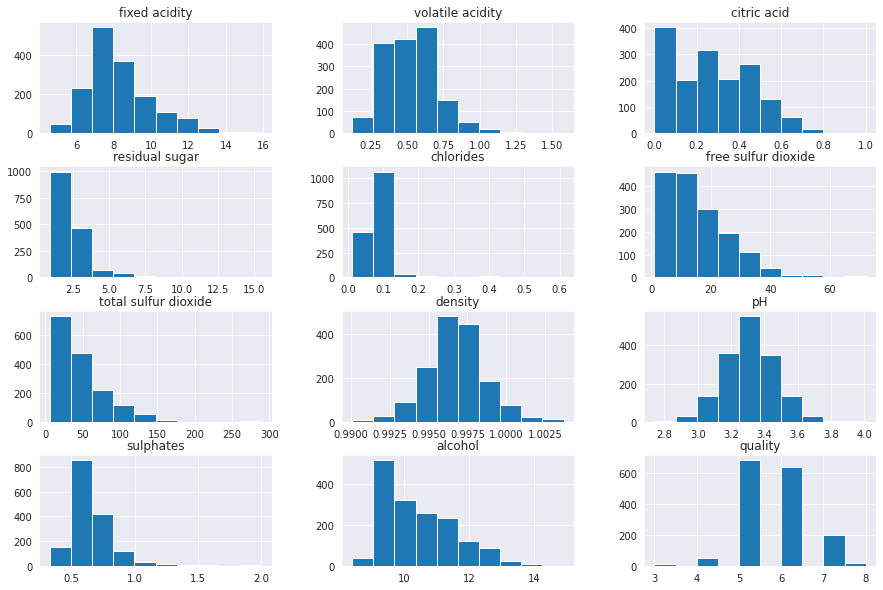

In [ ]:
df.hist(figsize=(15,10))
plt.show()

## Overview of the target feature

Total lines: 1599
Data types: int64
Total values: 1599
The most frequent value: 5
The less frequent value: 3
Unique values: 6
Missing values: 0


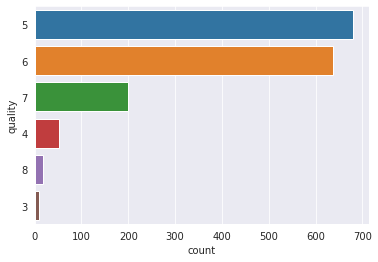

In [ ]:
cat_feature_overview(df.quality)

Distribution of the value alcohol

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


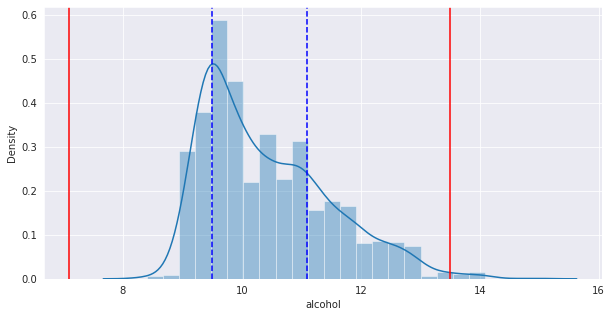

,Q1,Q3,IQR,low_outlier,high_outlier
0,9.5,11.1,1.6,7.1,13.5


In [ ]:
check_iqr(df.alcohol)

# 2. Feature engineering

convertation of  alcohol value to cat feature by following conditon:
'bad wine': quality < 6.5 & 'good wine': quality > 6.5

Target value

In [ ]:
#encoding the 'bad wine' as 0 and 'good wine' as 1
y = df.quality.apply(lambda x: '0' if x < 6.5 else '1') 


In [ ]:
y.value_counts()

0    1382
1     217
Name: quality, dtype: int64

Removing Target Variable i.e Quality

In [ ]:

X=df.iloc[:,:-1]

In [ ]:
X.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
120,7.3,1.070,0.09,1.7,0.178,10.0,89.0,0.9962,3.30,0.57,9.0
336,8.9,0.430,0.45,1.9,0.052,6.0,16.0,0.9948,3.35,0.70,12.5
380,8.3,0.260,0.42,2.0,0.080,11.0,27.0,0.9974,3.21,0.80,9.4
135,8.4,0.745,0.11,1.9,0.090,16.0,63.0,0.9965,3.19,0.82,9.6
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5


Data scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.52835961,  0.96187667, -1.39147228, ...,  1.28864292,
        -0.57920652, -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228, ..., -0.7199333 ,
         0.1289504 , -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, ..., -0.33117661,
        -0.04808883, -0.58477711],
       ...,
       [-1.1603431 , -0.09955388, -0.72391627, ...,  0.70550789,
         0.54204194,  0.54162988],
       [-1.39015528,  0.65462046, -0.77526673, ...,  1.6773996 ,
         0.30598963, -0.20930812],
       [-1.33270223, -1.21684919,  1.02199944, ...,  0.51112954,
         0.01092425,  0.54162988]])

Spliting the dataset into training and testing data

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [ ]:
#Kernel SVM model to classify.
from sklearn.svm import SVC

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train) # Fitting Kernel SVM to the Training set
#Predicting the Test Set
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'),"gamma": [0.1, 0.9], 'C':[1, 10, 100]}
grid_search = GridSearchCV(SVC(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("The best parameters are %s with a score of %0.2f"
    % (best_parameters, best_accuracy)
)


The best parameters are {'C': 1, 'gamma': 0.9, 'kernel': 'rbf'} with a score of 0.90


In [ ]:

gamma = 0.9
kernel = 'rbf'

# 3. Model

Fitting Kernel SVM to the Training set with best parameters

In [ ]:

from sklearn.svm import SVC
classifier = SVC(C=1.0, gamma=gamma, kernel=kernel)

classifier.fit(X_train, y_train)

#Predicting the Test Set
y_pred = classifier.predict(X_test)

In [ ]:

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.10625
Mean Squared Error: 0.10625
Root Mean Squared Error: 0.32596012026013244
